# Polscope segmentation and registration

In [1]:
import SimpleITK as sitk

import os
import sys
InDir = "F:/Box Sync/Research/Polarimetry/RAnalysis/WP4/"
OutDir = "F:/Box Sync/Research/Polarimetry/RAnalysis/WP4/JupyterOutput/"

#module_path = os.path.abspath(os.path.join('C:/Users/mpinkert/Documents/GitHub/SimpleITK-Notebooks/Utilities/'))
#if module_path not in sys.path:
 #   sys.path.append(module_path)
    
#from downloaddata import fetch_data as fdata

# setup our plotting environment
import matplotlib.pyplot as plt
%matplotlib inline

fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = fig_size[0]*2
fig_size[1] = fig_size[1]*2
plt.rcParams["figure.figsize"] = fig_size


## Utility functions

In [2]:
# GUI components (sliders, dropdown...).
from ipywidgets import interact, fixed

# Enable display of HTML.
from IPython.display import clear_output


# Callback invoked by the interact IPython method for scrolling through the image stacks of
# the two images (moving and fixed).
def display_images(fixed_npa, moving_npa):
    # Create a figure with two subplots and the specified size.
    plt.subplots(1,2,figsize=(10,8))
    
    # Draw the fixed image in the first subplot.
    plt.subplot(1,2,1)
    plt.imshow(fixed_npa[:,:],cmap=plt.cm.Greys_r);
    plt.title('fixed image')
    plt.axis('off')
    
    # Draw the moving image in the second subplot.
    plt.subplot(1,2,2)
    plt.imshow(moving_npa[:,:],cmap=plt.cm.Greys_r);
    plt.title('moving image')
    plt.axis('off')
    
    plt.show()
    
# Callback invoked by the IPython interact method for scrolling and modifying the alpha blending
# of an image stack of two images that occupy the same physical space. 
def display_images_with_alpha(alpha, fixed, moving):
    img = (1.0 - alpha)*fixed[:,:] + alpha*moving[:,:] 
    plt.imshow(sitk.GetArrayViewFromImage(img),cmap=plt.cm.Greys_r);
    plt.axis('off')
    plt.show()
    
def display_images_with_color(fixed,moving):
    img[:,:,1] = fixed
    img[:,:,2] = moving
    
    
    
# Callback invoked when the StartEvent happens, sets up our new data.
def start_plot():
    global metric_values, multires_iterations
    
    metric_values = []
    multires_iterations = []

# Callback invoked when the EndEvent happens, do cleanup of data and figure.
def end_plot():
    global metric_values, multires_iterations
    
    del metric_values
    del multires_iterations
    # Close figure, we don't want to get a duplicate of the plot latter on.
    plt.close()

# Callback invoked when the IterationEvent happens, update our data and display new figure.    
def plot_values(registration_method):
    global metric_values, multires_iterations
    
    metric_values.append(registration_method.GetMetricValue())                                       
    # Clear the output area (wait=True, to reduce flickering), and plot current data
    clear_output(wait=True)
    # Plot the similarity metric values
    plt.plot(metric_values, 'r')
    plt.plot(multires_iterations, [metric_values[index] for index in multires_iterations], 'b*')
    plt.xlabel('Iteration Number',fontsize=12)
    plt.ylabel('Metric Value',fontsize=12)
    plt.show()
    
# Callback invoked when the sitkMultiResolutionIterationEvent happens, update the index into the 
# metric_values list. 
def update_multires_iterations():
    global metric_values, multires_iterations

#def convertToDegrees(polImg, retCeiling)



## Read images

In [3]:
fixed_image = sitk.ReadImage(InDir + 'maskedFixed-weka-1xRes.tif', sitk.sitkFloat32)
moving_image = sitk.ReadImage(InDir + 'moving.tif', sitk.sitkFloat32)

interact(display_images, fixed_npa = fixed(sitk.GetArrayViewFromImage(fixed_image)), moving_npa=fixed(sitk.GetArrayViewFromImage(moving_image)));

A Jupyter Widget

## Update image data

## Initial Alignment

In [4]:
#This does an intitial alignment between the two images, and shows how they overlap pre-registration
initial_transform = sitk.Similarity2DTransform()

moving_resampled = sitk.Resample(moving_image, fixed_image, initial_transform, sitk.sitkLinear, 0.0, moving_image.GetPixelID())

interact(display_images_with_alpha, alpha=(0.0,1.0,0.05), fixed = fixed(fixed_image), moving=fixed(moving_resampled));

A Jupyter Widget

## Affine Registration

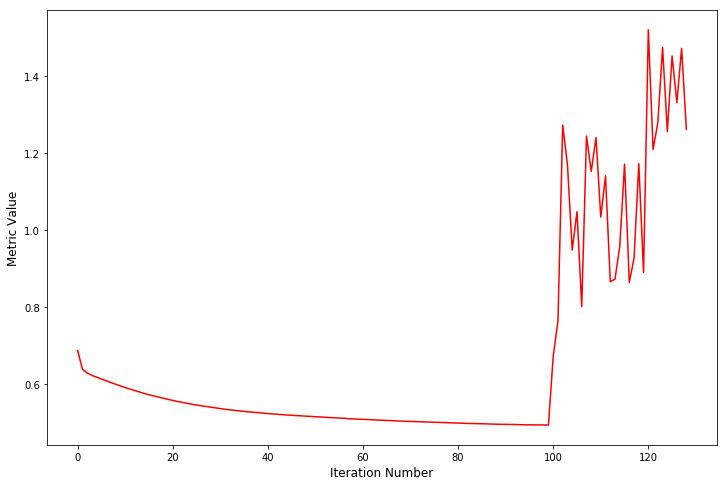

Final metric value: 1.4663372874994596
Optimizer's stopping condition, GradientDescentOptimizerv4Template: Convergence checker passed at iteration 9.


In [5]:
#def affine_registration(fixed_image,moving_image):
registration_method = sitk.ImageRegistrationMethod()

 # Similarity metric settings.|
registration_method.SetMetricAsMeanSquares()
registration_method.SetMetricSamplingStrategy(registration_method.RANDOM)
registration_method.SetMetricSamplingPercentage(1)

registration_method.SetInterpolator(sitk.sitkLinear)

    # Optimizer settings.
registration_method.SetOptimizerAsGradientDescent(learningRate=1.0, numberOfIterations=100, convergenceMinimumValue=1e-6, convergenceWindowSize=10)
registration_method.SetOptimizerScalesFromPhysicalShift()

    # Setup for the multi-resolution framework.            
registration_method.SetShrinkFactorsPerLevel(shrinkFactors = [8,4,2,1])
registration_method.SetSmoothingSigmasPerLevel(smoothingSigmas=[4,2,1,0])
registration_method.SmoothingSigmasAreSpecifiedInPhysicalUnitsOn()
    
    #Redefining initial_transform so the function 
initial_transform = sitk.AffineTransform(2)

    # Don't optimize in-place, we would possibly like to run this cell multiple times.
registration_method.SetInitialTransform(initial_transform, inPlace=False)

    # Connect all of the observers so that we can perform plotting during registration.
registration_method.AddCommand(sitk.sitkStartEvent, start_plot)
registration_method.AddCommand(sitk.sitkEndEvent, end_plot)
registration_method.AddCommand(sitk.sitkMultiResolutionIterationEvent, update_multires_iterations) 
registration_method.AddCommand(sitk.sitkIterationEvent, lambda: plot_values(registration_method))
    
affine_transform = registration_method.Execute(fixed_image,moving_image)
print('Final metric value: {0}'.format(registration_method.GetMetricValue()))
print('Optimizer\'s stopping condition, {0}'.format(registration_method.GetOptimizerStopConditionDescription()))

    
    #return (registration_method.Execute(fixed_image,moving_image), registration_method.GetMetricValue(), registration_method.GetOptimizerStopConditionDescription())

In [6]:
#(affine_transform, affine_metric, affine_stop) = affine_registration(fixed_image,moving_image)
#print('Final metric value: {0}'.format(affine_metric))
#print('Optimizer\'s stopping condition, {0}'.format(affine_stop))
print('Final metric value: {0}'.format(registration_method.GetMetricValue()))
print('Optimizer\'s stopping condition, {0}'.format(registration_method.GetOptimizerStopConditionDescription()))


Final metric value: 1.4663372874994596
Optimizer's stopping condition, GradientDescentOptimizerv4Template: Convergence checker passed at iteration 9.


## Affine analysis

In [7]:
affine_resampled = sitk.Resample(moving_image, fixed_image, affine_transform, sitk.sitkLinear, 0.0, moving_image.GetPixelID())

interact(display_images_with_alpha, alpha=(0.0,1.0,0.05), fixed = fixed(fixed_image), moving=fixed(affine_resampled));

A Jupyter Widget

In [8]:
writer = sitk.ImageFileWriter()
#writer.SetFileName(OutDir + 'jupyterAffine_mean_4Pyramid_gradDes_lr1_conMin-1e-6_.tif')
#writer.Execute(affine_resampled)

## Bspline registration

In [9]:
def bspline_registration(fixed_image, moving_image, fixed_image_mask=None, fixed_points=None, moving_points=None):

    registration_method = sitk.ImageRegistrationMethod()
    
    # Determine the number of BSpline control points using the physical spacing we want for the control grid. 
    grid_physical_spacing = [10, 10] 
    image_physical_size = [size*spacing for size,spacing in zip(fixed_image.GetSize(), fixed_image.GetSpacing())]
    mesh_size = [int(image_size/grid_spacing + 0.5) \
                 for image_size,grid_spacing in zip(image_physical_size,grid_physical_spacing)]

    initial_transform = sitk.BSplineTransformInitializer(image1 = fixed_image, 
                                                         transformDomainMeshSize = mesh_size, order=3)    
    registration_method.SetInitialTransform(initial_transform)
        
    registration_method.SetMetricAsMeanSquares()
    # Settings for metric sampling, usage of a mask is optional. When given a mask the sample points will be 
    # generated inside that region. Also, this implicitly speeds things up as the mask is smaller than the
    # whole image.
    registration_method.SetMetricSamplingStrategy(registration_method.RANDOM)
    registration_method.SetMetricSamplingPercentage(1)
    if fixed_image_mask:
        registration_method.SetMetricFixedMask(fixed_image_mask)
    
    # Multi-resolution framework.            
    registration_method.SetShrinkFactorsPerLevel(shrinkFactors = [8,4,2,1])
    registration_method.SetSmoothingSigmasPerLevel(smoothingSigmas=[4,2,1,0])
    registration_method.SmoothingSigmasAreSpecifiedInPhysicalUnitsOn()

    registration_method.SetInterpolator(sitk.sitkLinear)
    
    registration_method.SetOptimizerAsGradientDescent(learningRate=1.0, numberOfIterations=100, convergenceMinimumValue=1e-6, convergenceWindowSize=10)
    registration_method.SetOptimizerScalesFromPhysicalShift()

        # Connect all of the observers so that we can perform plotting during registration.
    registration_method.AddCommand(sitk.sitkStartEvent, start_plot)
    registration_method.AddCommand(sitk.sitkEndEvent, end_plot)
    registration_method.AddCommand(sitk.sitkMultiResolutionIterationEvent, update_multires_iterations) 
    registration_method.AddCommand(sitk.sitkIterationEvent, lambda: plot_values(registration_method))


    # If corresponding points in the fixed and moving image are given then we display the similarity metric
    # and the TRE during the registration.
    if fixed_points and moving_points:
        registration_method.AddCommand(sitk.sitkStartEvent, rc.metric_and_reference_start_plot)
        registration_method.AddCommand(sitk.sitkEndEvent, rc.metric_and_reference_end_plot)
        registration_method.AddCommand(sitk.sitkIterationEvent, lambda: rc.metric_and_reference_plot_values(registration_method, fixed_points, moving_points))
    
    return (registration_method.Execute(fixed_image,moving_image), registration_method.GetMetricValue(), registration_method.GetOptimizerStopConditionDescription())

In [10]:
#(bspline_transform, bspline_metric, bspline_stop) = bspline_registration(fixed_image,moving_image, None, None, None)
#print('Final metric value: {0}'.format(bspline_metric))
#print('Optimizer\'s stopping condition, {0}'.format(bspline_stop))

## Bspline analysis

In [11]:
#bspline_resampled = sitk.Resample(moving_image, fixed_image, affine_transform, sitk.sitkLinear, 0.0, moving_image.GetPixelID())

#interact(display_images_with_alpha, alpha=(0.0,1.0,0.05), fixed = fixed(fixed_image), moving=fixed(bspline_resampled));

In [12]:
#writer2 = sitk.ImageFileWriter()
#writer2.SetFileName(OutDir + 'jupyterBspline_Grid-10x10_mean_4Pyramid_gradDes_lr1_conMin-1e-6_.tif')
#writer2.Execute(bspline_resampled)